# This Jupyter Notebook is Provided for the Purpose of Reproducing the Analysis in Boughter & Meier-Schellersheim 2022
Specifically "A Systematic Characterization of Germline Contacts Identifies the Source of Bias in TCR-MHC Interactions", currently released in preprint form

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import mdtraj as md
import matplotlib as mpl
import os
import pandas
import itertools
from matplotlib import rc
from matplotlib import rcParams

# Woohoo my own homemade scripts!
import tcr_structParse as tcrParse

# If you want your own custom analysis, you can run run "parser_main.py" to get back out Distances from PDBs with your own custom settings
For now, I've included the distances used for the analysis in the MHC Germline Manuscript. Files are small enough so easy to include.

# Also, for the below section, got negative feedback in the reviews for the way that I classified "Interactions"
Now this is a little tricky to change. Not in the code, that's easy. But in reasonably breaking down how TCRs and MHCs interact.

I think the reviewer entirely missed the mark, and isn't understanding that we're trying to break these complexes down to their essences.

# Below we now have the second version of this PRESTO scoring, see reviews and manuscript for details

In [ ]:
# In this bit of script, we further process the sidechain distances from the PDBs
# We select out only the "productive" interactions O-N, H-O, H-N, or C-C
# Further, only allow C-C contacts with non-clashing residues
# Also ensure that we are matching these with the PDB ID and the TRAV/TRBV allele

########## MOST IMPORTANT BIT TO START (AND LATER ON) #################
# Define which MHC class you are interested in
mhc_class = 1
######################################################################

if mhc_class == 2:
    input_df = pandas.read_csv('tcr3d_classIImeta.csv')
    #path = 'classII_dist/'
    path = 'classII_back_side/'
else:
    input_df = pandas.read_csv('tcr3d_classImeta.csv')
    #path = 'classI_dist/'
    path = 'classI_back_side/'
    
human_df = input_df[input_df['Species'] == 'Human']

phob = ['ILE','PHE','MET','LEU','VAL','ALA','GLY','PRO','TRP']
# So hybrid meant phobic/philic hybrids in the prepint version
# Now it means those residues that *can* form O-O or N-N hydrogen bond pairs (the same atom can be donor OR acceptor)
# If one of these residues are involved in an interaction, allow for O-O or N-N interactions
hybrid = ['SER','THR','TYR','HIS']
phillic = ['ASN','GLN','CYS']
pos = ['ARG','LYS']; neg = ['ASP','GLU']

x = os.listdir(path)
first = True
# For every file in the given directory...
for i in x:
    # Make sure we are only taking out the
    # files that are from the output of the parser_main.py
    if i[-9:] == 'dists.csv':
        temp_pdb = i[:4]
        # Pull out the PDB/TRAV/TRBV information
        pdb_info = human_df[human_df['PDB<BR>ID'] == temp_pdb]
        temp_trav = pdb_info['TRAV<BR>gene'].values[0]
        temp_trbv = pdb_info['TRBV<BR>gene'].values[0]
        temp_df = pandas.read_csv(path+i)
        # Pull out the MHC information
        mhcID_temp = input_df[input_df['PDB<BR>ID'] == temp_pdb]['MHC<BR>Name'].values[0]
        for j in np.arange(len(temp_df)):
            save = False
            tcr_atom = temp_df.loc[j]['tcrName'][0]
            mhc_atom = temp_df.loc[j]['mhcName'][0]
            tcrRes = temp_df.loc[j]['tcrRes']
            mhcRes = temp_df.loc[j]['mhcRes']
            atom_int = tcr_atom+mhc_atom
            distance = temp_df.loc[j]['distance']
            # Then go through and try to find good interactors
            if atom_int == 'ON' or atom_int == 'NO':
                save = True
            elif atom_int == 'HO' or atom_int == 'OH':
                save = True
            elif atom_int == 'HN' or atom_int == 'NH':
                save = True
            elif atom_int == 'CC':
                # Be more stringent with CC interactions
                if distance < 0.45:
                    save = True
            elif atom_int == 'OO' or atom_int == 'NN':
                if tcrRes in hybrid:
                    save = True
                elif mhcRes in hybrid:
                    save = True
            
            if save:
                tcrRes = temp_df.loc[j]['tcrRes']
                tcrNum = temp_df.loc[j]['tcrNum']
                mhcRes = temp_df.loc[j]['mhcRes']
                mhcNum = temp_df.loc[j]['mhcNum']
                loop = temp_df.loc[j]['loop']
                dist = temp_df.loc[j]['distance']
                if mhc_class == 2:
                    mhc_chain = temp_df.loc[j]['mhc_chain']
                    holdit = [temp_pdb,mhcID_temp,atom_int,tcrRes,tcrNum,mhcRes,mhcNum,loop,temp_trav,temp_trbv,mhc_chain,dist]
                else:
                    holdit = [temp_pdb,mhcID_temp,atom_int,tcrRes,tcrNum,mhcRes,mhcNum,loop,temp_trav,temp_trbv,dist]
                if first:
                    final_df = np.transpose(pandas.DataFrame(holdit))
                    first = False
                else:
                    final_df = pandas.concat([final_df,np.transpose(pandas.DataFrame(holdit))])


# Have a final dataframe with all of this information
final_contacts = final_df.drop_duplicates()
if mhc_class == 2:
    final_contacts.columns = ['PDB','mhcID','Atoms','tcrRes','tcrNum','mhcRes','mhcNum','Loop','TRAV','TRBV','mhc_chain']
else:
    final_contacts.columns = ['PDB','mhcID','Atoms','tcrRes','tcrNum','mhcRes','mhcNum','Loop','TRAV','TRBV']
final_contacts.index = np.arange(len(final_contacts))

# These are the new PRESTO outputs necessary for completing the MHC Germline Analysis

In [ ]:
# identify duplicate interactions between residues and keep only the "best" one
iden_sub = final_df[['PDB','tcrNum','mhcNum']]
nondup_contacts = final_df[~iden_sub.duplicated(keep=False)]

# So for some reason "keep" is what you are not including in "duplicated"?
# Idk it is written in a very counter-intuitive way, but this FOR loop
# will include EVERYTHING we want
hold_df = []
for set in final_df[~iden_sub.duplicated(keep='first')][['PDB','tcrNum','mhcNum']].values:
    pdb = set[0]; tcrnum = set[1]; mhcnum = set[2]
    sub1 = final_df[final_df['PDB'] == pdb]
    sub2 = sub1[sub1['tcrNum']==tcrnum]
    sub3 = sub2[sub2['mhcNum']==mhcnum]

    # So we are sorting the distances of each residue
    # And only keeping the closest one.
    hold_df = hold_df + [sub3.sort_values('Dist').iloc[0]]

best_res_contacts = pandas.DataFrame(hold_df)

# So I now believe that best_res_contacts should be EXACTLY what we want.
# No double counting, only taking the closest (and likely best!) interactions
best_res_contacts.to_csv('back_side_class1.csv',index=False)

# EVERYTHING BELOW HERE IS THE *OLD* WAY OF LOOKING AT THE OUTPUTS

In [3]:
# Process a little more to separate things out by CDR
# For a lot of the analysis, we only need a per-PDB breakdown
# on the number of counts for each PDB
fin=[]
for i in final_contacts['PDB'].drop_duplicates().values:
    count_1a = 0;count_2a = 0;count_1b=0;count_2b=0
    xx = final_contacts[final_contacts['PDB'] == i]
    trav= final_contacts[final_contacts['PDB'] == i]['TRAV'].drop_duplicates().values[0]
    trbv= final_contacts[final_contacts['PDB'] == i]['TRBV'].drop_duplicates().values[0]
    count_1a = len(xx[xx['Loop']=='cdr1a'])
    count_2a = len(xx[xx['Loop']=='cdr2a'])
    count_1b = len(xx[xx['Loop']=='cdr1b'])
    count_2b = len(xx[xx['Loop']=='cdr2b'])
    fin = fin+[[i,trav,trbv,count_1a,count_2a,count_1b,count_2b]]
fin_df = pandas.DataFrame(fin)
fin_df.columns = ['PDB','TRAV','TRBV','CDR1A','CDR2A','CDR1B','CDR2B']

# You Now Have All the Information on the PDB Side to Make Comparisons to AIMS Interaction Scores
# Now, Load Back in AIMS Interaction Score By-Residue Breakdowns to Complete the Comparison

In [5]:
if mhc_class == 1:
    a1_breakdown = pandas.read_csv('interact_scores/classI_a1_breakdown.csv',index_col=0)
    a2_breakdown = pandas.read_csv('interact_scores/classI_a2_breakdown.csv',index_col=0)
    b1_breakdown = pandas.read_csv('interact_scores/classI_b1_breakdown.csv',index_col=0)
    b2_breakdown = pandas.read_csv('interact_scores/classI_b2_breakdown.csv',index_col=0)
elif mhc_class == 2:
    # Note, we are only loading in the "proper" interaction scores. i.e. alpha chain
    # with TCRbeta, beta chain with TCRalpha. hence only having 4 files here
    a1_breakdown = pandas.read_csv('interact_scores/classIIb_a1_breakdown.csv',index_col=0)
    a2_breakdown = pandas.read_csv('interact_scores/classIIb_a2_breakdown.csv',index_col=0)
    b1_breakdown = pandas.read_csv('interact_scores/classIIa_b1_breakdown.csv',index_col=0)
    b2_breakdown = pandas.read_csv('interact_scores/classIIa_b2_breakdown.csv',index_col=0)


# Break Down these breakdowns into a by-CDR score

In [6]:
cdr1b_score = []; cdr2b_score = []
for i in fin_df['TRBV'].values:
    cdr1b_score = cdr1b_score + [np.average(b1_breakdown.loc[i].values)]
    cdr2b_score = cdr2b_score + [np.average(b2_breakdown.loc[i].values)]
cdr1a_score = []; cdr2a_score = []
for i in fin_df['TRAV'].values:
    cdr1a_score = cdr1a_score + [np.average(a1_breakdown.loc[i].values)]
    cdr2a_score = cdr2a_score + [np.average(a2_breakdown.loc[i].values)]

# This next cell is solely for making plots look better

In [7]:
# You can edit these at some point if you want to change the formatting of your figures
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

# Custom colormap code from: https://stackoverflow.com/questions/49367144/modify-matplotlib-colormap
import matplotlib as mpl
upper = mpl.cm.jet(np.arange(256))
lower = np.ones((int(256/4),4))
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

cmap = np.vstack(( lower, upper ))
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

# Plot the CDR-MHC Contacts Broken Down by Interaction Prediction

Text(0,0.5,'Count')

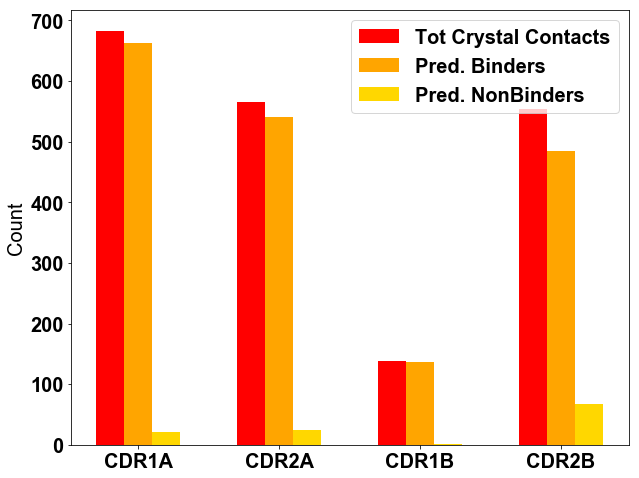

In [8]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
compare_metrics1a = np.transpose(pandas.DataFrame([cdr1a_score,fin_df['CDR1A'],fin_df['TRAV'],fin_df['PDB']]))
compare_metrics1b = np.transpose(pandas.DataFrame([cdr1b_score,fin_df['CDR1B'],fin_df['TRBV'],fin_df['PDB']]))
compare_metrics2a = np.transpose(pandas.DataFrame([cdr2a_score,fin_df['CDR2A'],fin_df['TRAV'],fin_df['PDB']]))
compare_metrics2b = np.transpose(pandas.DataFrame([cdr2b_score,fin_df['CDR2B'],fin_df['TRBV'],fin_df['PDB']]))

label=['CDR1A','CDR2A','CDR1B','CDR2B']
xaxis = [1,2,3,4]
cryst_contacts=[sum(compare_metrics1a[1].values),sum(compare_metrics2a[1].values),
 sum(compare_metrics1b[1].values),sum(compare_metrics2b[1].values)]
pred0_1a = sum(compare_metrics1a[compare_metrics1a[0] == 0][1])
pred0_2a = sum(compare_metrics2a[compare_metrics2a[0] == 0][1])
pred0_1b = sum(compare_metrics1b[compare_metrics1b[0] == 0][1])
pred0_2b = sum(compare_metrics2b[compare_metrics2b[0] == 0][1])

pred_1a = sum(compare_metrics1a[compare_metrics1a[0] != 0][1])
pred_2a = sum(compare_metrics2a[compare_metrics2a[0] != 0][1])
pred_1b = sum(compare_metrics1b[compare_metrics1b[0] != 0][1])
pred_2b = sum(compare_metrics2b[compare_metrics2b[0] != 0][1])

pred_contacts = [pred_1a,pred_2a,pred_1b,pred_2b]
predZero_contacts = [pred0_1a,pred0_2a,pred0_1b,pred0_2b]

pl.bar(xaxis,cryst_contacts,width=0.2,color='red')
pl.bar(xaxis+np.ones(4)*0.2,pred_contacts,width=0.2,color='orange')
pl.bar(xaxis+np.ones(4)*0.4,predZero_contacts,width=0.2,color='gold')

xax=pl.setp(ax[0,0],xticks=np.arange(4)+1.2,xticklabels=label)
pl.legend(['Tot Crystal Contacts','Pred. Binders','Pred. NonBinders'])
pl.ylabel('Count')
#pl.savefig('classII_struct_breakdown.pdf',format='pdf')

# Plot the CDRs that Don't Contact MHC Broken Down by Interaction Prediction

Text(0,0.5,'Count')

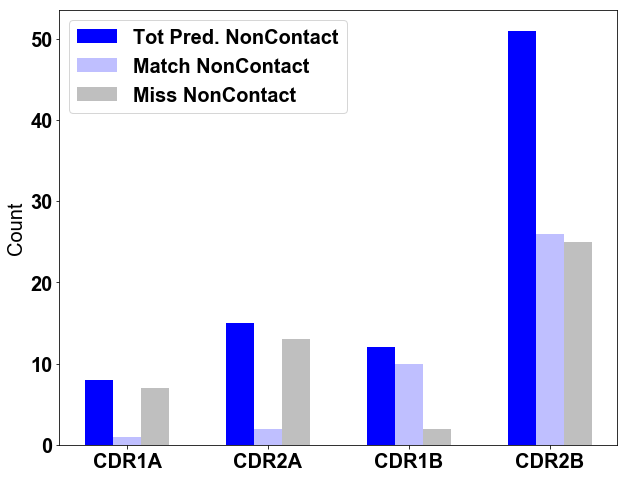

In [9]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))

pred0_1a = compare_metrics1a[compare_metrics1a[0] == 0]
pred0_2a = compare_metrics2a[compare_metrics2a[0] == 0]
pred0_1b = compare_metrics1b[compare_metrics1b[0] == 0]
pred0_2b = compare_metrics2b[compare_metrics2b[0] == 0]

matchPred_1a = len(pred0_1a[pred0_1a[1] == 0])
matchPred_2a = len(pred0_2a[pred0_2a[1] == 0])
matchPred_1b = len(pred0_1b[pred0_1b[1] == 0])
matchPred_2b =  len(pred0_2b[pred0_2b[1] == 0])

missPred_1a = len(pred0_1a[pred0_1a[1] != 0])
missPred_2a = len(pred0_2a[pred0_2a[1] != 0])
missPred_1b = len(pred0_1b[pred0_1b[1] != 0])
missPred_2b =  len(pred0_2b[pred0_2b[1] != 0])

cryst_contacts = [len(pred0_1a),len(pred0_2a),len(pred0_1b),len(pred0_2b)]
match_contacts = [matchPred_1a,matchPred_2a,matchPred_1b,matchPred_2b]
miss_contacts = [missPred_1a,missPred_2a,missPred_1b,missPred_2b]

label=['CDR1A','CDR2A','CDR1B','CDR2B']
xaxis = [1,2,3,4]

pl.bar(xaxis,cryst_contacts,width=0.2,color='blue')
pl.bar(xaxis+np.ones(4)*0.2,match_contacts,width=0.2,color='blue',alpha=0.25)
pl.bar(xaxis+np.ones(4)*0.4,miss_contacts,width=0.2,color='grey',alpha=0.5)

xax=pl.setp(ax[0,0],xticks=np.arange(4)+1.2,xticklabels=label)
pl.legend(['Tot Pred. NonContact','Match NonContact','Miss NonContact'])
pl.ylabel('Count')
#pl.savefig('classII_struct_breakdown_NoContact.pdf',format='pdf')

# Independent of Score, Need to Identify Number of Contacts with a Given MHC Residue
Rather than averaging things over all residues per CDR loop as above

In [10]:
if mhc_class == 1:
    alpha1 = [55,56,59,60,63,66,67,70,74,77,80]
    pep_contact = [3,5,7,20,22,24,43,57,61,64,65,68,71,72,75,78,79,82,93,95,97,112,114,141,145,150,154,157,169]
    alpha2 = [143,144,147,148,149,152,153,156,160,161,164,165,167,168]
    hlaA_0101 = 'SHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEPRAPWIEQEGPEYWDQETRNMKAHSQTDRANLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAVHAAEQRRVYLEGRCVDGLRRYLENGKETL'
    alpha1_seq = []
    for i in alpha1:
        let = hlaA_0101[i]
        alpha1_seq = alpha1_seq + [let]

    alpha2_seq = []
    for i in alpha2:
        let = hlaA_0101[i]
        alpha2_seq = alpha2_seq + [let]

    alpha1_seqF = ''.join(alpha1_seq)
    # Generate a dataframe to count all of these contacts
    # THIS ONE IS FOR CLASS I
    alpha_list = alpha1+alpha2
    cdrs = ['cdr1a','cdr2a','cdr1b','cdr2b']
    count_contacts_df = pandas.DataFrame(np.zeros((len(alpha_list),len(cdrs))))
    count_contacts_df.columns = cdrs
    count_contacts_df.index = alpha_list
    a=0
    for i in np.arange(len(final_contacts)):
        subset = final_contacts.loc[i]
        for num in alpha_list:
            if num == subset.mhcNum:
                count_contacts_df.loc[num][subset.Loop] += 1
                a += 1
                
elif mhc_class == 2:
    II_alpha_contacts = [51, 53, 55, 56, 58, 59, 62, 63, 66, 69, 70, 73, 74]
    II_beta_contacts = [63, 66, 67, 70, 71, 73, 74, 76, 77, 80, 83, 84, 87, 88, 91, 92]
    # Pick just the first listed HLA DQ alleles
    hla_dqa1_01 = 'ADHVASCGVNLYQFYGPSGQYTHEFDGDEEFYVDLERKETAWRWPEFSKFGGFDPQGALRNMAVAKHNLNIMIKRYNST'
    hla_dqb1_02 = 'LSTPVAEGRDSPEDFVYQFKGMCYFTNGTERVRLVSRSIYNREEIVRFDSDVGEFRAVTLLGLPAAEYWNSQKDILERKRAAVDRVCRHNYQLELRTTLQ'
    # THIS ONE IS FOR CLASS II
    cdrs = ['cdr1a','cdr2a','cdr1b','cdr2b']
    alpha_contacts_df = pandas.DataFrame(np.zeros((len(II_alpha_contacts),len(cdrs))))
    alpha_contacts_df.columns = cdrs
    alpha_contacts_df.index = II_alpha_contacts

    beta_contacts_df = pandas.DataFrame(np.zeros((len(II_beta_contacts),len(cdrs))))
    beta_contacts_df.columns = cdrs
    beta_contacts_df.index = II_beta_contacts
    
    alpha_list = II_alpha_contacts + II_beta_contacts

    a=0
    for i in np.arange(len(final_contacts)):
        subset = final_contacts.loc[i]
        if subset.mhc_chain == 'mhc_alpha':
            for num in II_alpha_contacts:
                if num == subset.mhcNum:
                    alpha_contacts_df.loc[num][subset.Loop] += 1
                    a += 1
        if subset.mhc_chain == 'mhc_beta':
            for num in II_beta_contacts:
                if num == subset.mhcNum:
                    beta_contacts_df.loc[num][subset.Loop] += 1
                    a += 1

    count_contacts_df = pandas.concat([alpha_contacts_df,beta_contacts_df])

# Plot Stacked Bar Plots of Crystal Contacts as a Function of Position
In the paper, these are matched up with by-residue interaction potentials, which are calculated in the AIMS analysis (as with most of the things in this particular manuscript).

Text(0,0.5,'Contact Count')

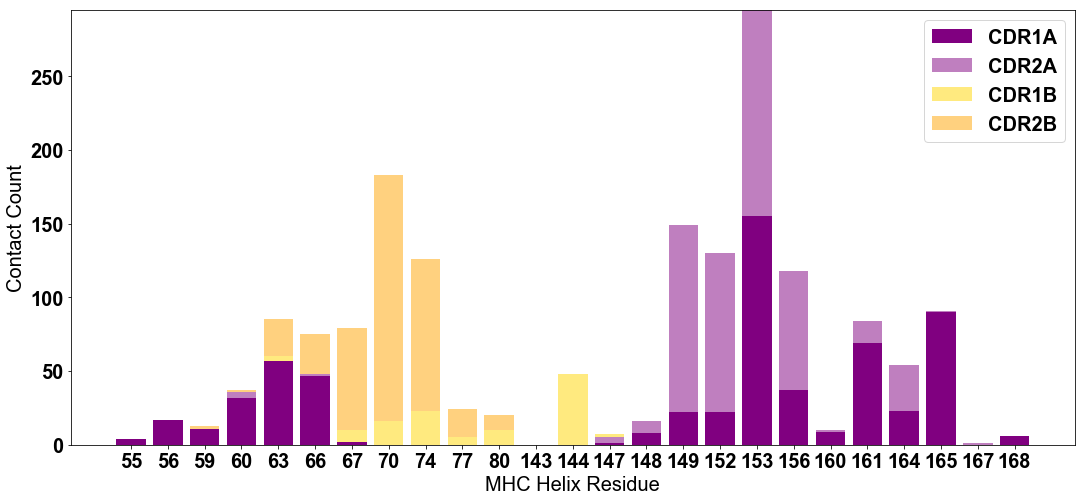

In [12]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(18,8))

not_2a = count_contacts_df['cdr1a'].values
not_1b = count_contacts_df['cdr2a'].values + count_contacts_df['cdr1a'].values
not_2b = count_contacts_df['cdr2a'].values + count_contacts_df['cdr1b'].values + count_contacts_df['cdr1a'].values

pl.bar(np.arange(len(count_contacts_df['cdr1a'].values)),count_contacts_df['cdr1a'].values,color='purple')
pl.bar(np.arange(len(count_contacts_df['cdr2a'].values)),count_contacts_df['cdr2a'].values,bottom = not_2a,color='purple',alpha=0.5)

pl.bar(np.arange(len(count_contacts_df['cdr1b'].values)),count_contacts_df['cdr1b'].values,bottom = not_1b,color='gold',alpha=0.5)
pl.bar(np.arange(len(count_contacts_df['cdr2b'].values)),count_contacts_df['cdr2b'].values,bottom = not_2b,color='orange',alpha=0.5)

label= alpha_list
xaxis = np.arange(len(label))
xax=pl.setp(ax[0,0],xticks=xaxis,xticklabels=label)

#pl.ylim([0,35])
pl.legend(['CDR1A','CDR2A','CDR1B','CDR2B'])
pl.xlabel('MHC Helix Residue')
pl.ylabel('Contact Count')
#pl.savefig('class'+str(mhc_class)+'_crystal_contacts.pdf',format='pdf')